# Sierra Leone Solar Data EDA
Exploratory Data Analysis for the Sierra Leone solar dataset.

In [2]:
import pandas as pd
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
from windrose import WindroseAxes


In [3]:

# Load dataset
df = pd.read_csv('../data/solar-measurements_sierraleone-bumbuna_qc.csv', encoding='latin1', skiprows=[1])

# Convert to numeric and clean units
key_columns = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
for col in key_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = df[col].fillna(df[col].median())

# Ensure non-negative values
for col in ['GHI', 'DNI', 'DHI']:
    df[col] = df[col].clip(lower=0)

# Drop columns with >50% missing values
df = df.loc[:, df.isna().mean() < 0.5]

# Export cleaned data
df.to_csv('../data/sierraleone_clean.csv', index=False)

# Verify
print("Sierra Leone Cleaned Sample:\n", df[['GHI', 'DNI', 'DHI']].head())
print("\nSierra Leone Stats:\n", df[['GHI', 'DNI', 'DHI']].describe())
print("\nNegative Values Check:")
print("Negative GHI:", (df['GHI'] < 0).sum())
print("Negative DNI:", (df['DNI'] < 0).sum())
print("Negative DHI:", (df['DHI'] < 0).sum())

Sierra Leone Cleaned Sample:
    GHI  DNI  DHI
0  0.0  0.0  0.0
1  0.0  0.0  0.0
2  0.0  0.0  0.0
3  0.0  0.0  0.0
4  0.0  0.0  0.0

Sierra Leone Stats:
                  GHI            DNI            DHI
count  525600.000000  525600.000000  525600.000000
mean      204.406778     116.523731     116.273677
std       296.787520     218.573992     157.020868
min         0.000000       0.000000       0.000000
25%         0.000000       0.000000       0.000000
50%         0.300000       0.000000       0.000000
75%       362.400000     107.000000     224.700000
max      1499.000000     946.000000     892.000000

Negative Values Check:
Negative GHI: 0
Negative DNI: 0
Negative DHI: 0


In [4]:
# Summary statistics
summary_stats = df.describe()
print(summary_stats)

                 GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      204.406778     116.523731     116.273677     206.643095   
std       296.787520     218.573992     157.020868     300.896893   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.300000       0.000000       0.000000       3.600000   
75%       362.400000     107.000000     224.700000     359.500000   
max      1499.000000     946.000000     892.000000    1507.000000   

                ModB           Tamb             RH             WS  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      198.114691      26.319394      79.448857       1.146113   
std       288.889073       4.398605      20.520775       1.239248   
min         0.000000      12.300000       9.900000       0.000000   
25%         0.000000      23.1000

In [5]:
# Compute Z-scores
z_scores = df[key_columns].apply(zscore, nan_policy='omit')
# Flag outliers (|Z| > 3)
outliers = (z_scores.abs() > 3).any(axis=1)
print(f"Number of rows with outliers: {outliers.sum()}")

Number of rows with outliers: 16547


In [6]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

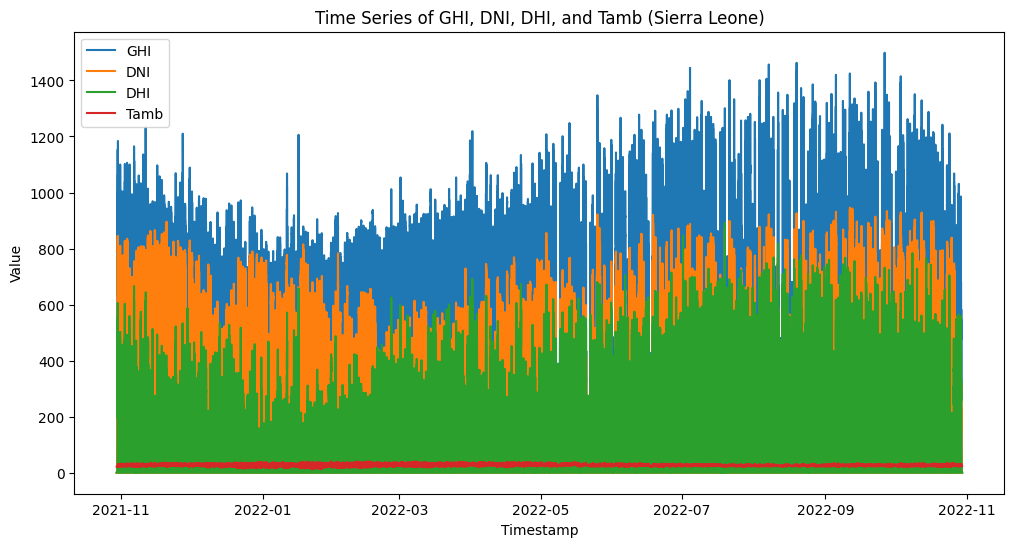

In [7]:

# Line plots
plt.figure(figsize=(12, 6))
plt.plot(df['Timestamp'], df['GHI'], label='GHI')
plt.plot(df['Timestamp'], df['DNI'], label='DNI')
plt.plot(df['Timestamp'], df['DHI'], label='DHI')
plt.plot(df['Timestamp'], df['Tamb'], label='Tamb')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Time Series of GHI, DNI, DHI, and Tamb (Sierra Leone)')
plt.legend()
plt.show()

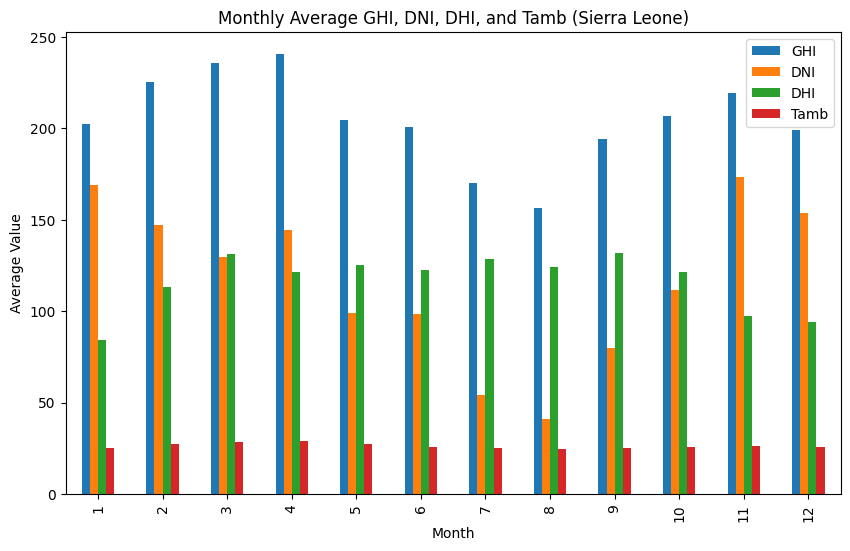

In [8]:
df['Month'] = df['Timestamp'].dt.month
monthly_stats = df.groupby('Month')[['GHI', 'DNI', 'DHI', 'Tamb']].mean()

# Create bar chart for monthly averages
monthly_stats.plot(kind='bar', figsize=(10, 6))
plt.title('Monthly Average GHI, DNI, DHI, and Tamb (Sierra Leone)')
plt.xlabel('Month')
plt.ylabel('Average Value')
plt.show()

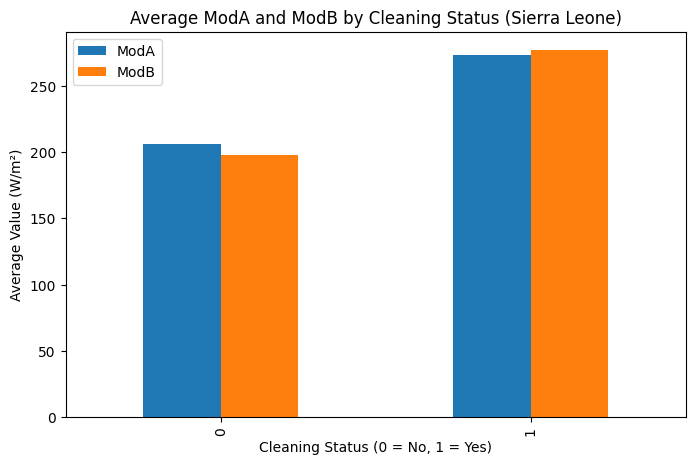

In [9]:
# Group by Cleaning flag and calculate average ModA and ModB
cleaning_impact = df.groupby('Cleaning')[['ModA', 'ModB']].mean()

# Plot bar chart
cleaning_impact.plot(kind='bar', figsize=(8, 5))
plt.title('Average ModA and ModB by Cleaning Status (Sierra Leone)')
plt.xlabel('Cleaning Status (0 = No, 1 = Yes)')
plt.ylabel('Average Value (W/m²)')
plt.show()

Cleaning events improve ModA and ModB readings, indicating reduced soiling effects.

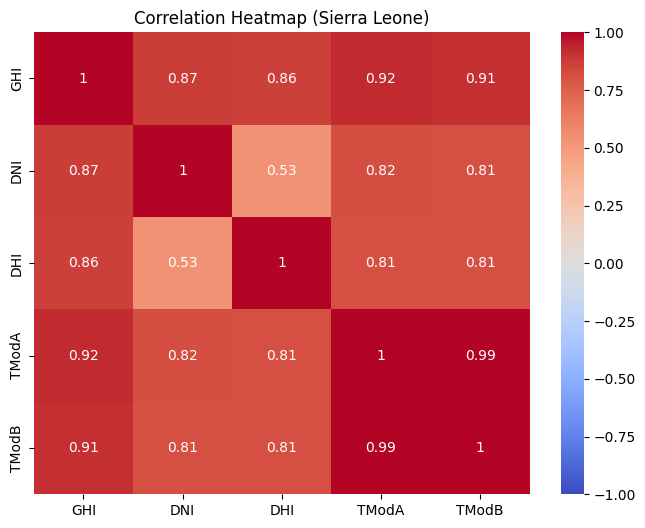

In [10]:
# Correlation matrix
correlation_matrix = df[['GHI', 'DNI', 'DHI', 'TModA', 'TModB']].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap (Sierra Leone)')
plt.show()

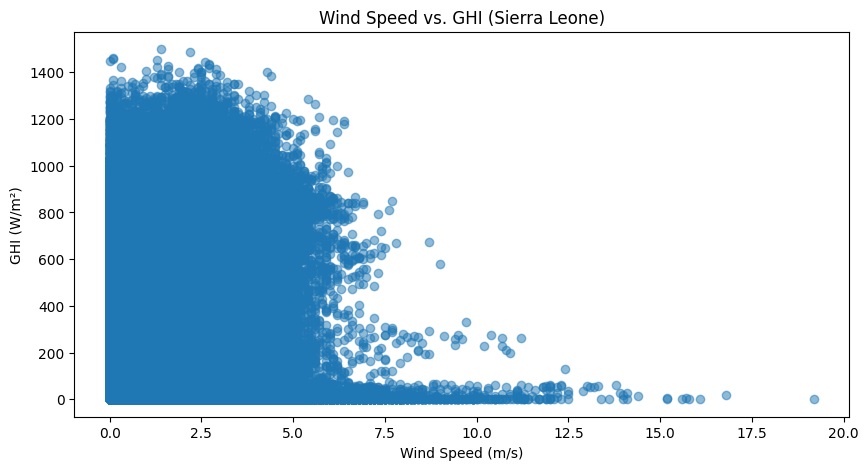

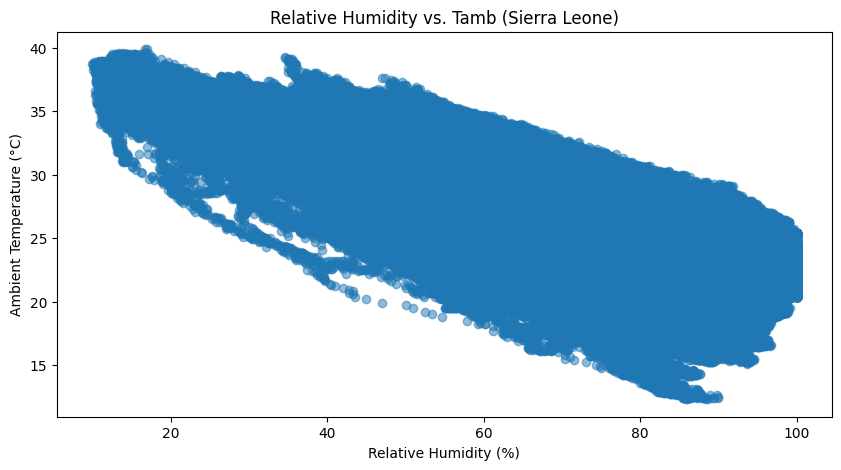

In [11]:
# Scatter plot: Wind Speed vs. GHI
plt.figure(figsize=(10, 5))
plt.scatter(df['WS'], df['GHI'], alpha=0.5)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('GHI (W/m²)')
plt.title('Wind Speed vs. GHI (Sierra Leone)')
plt.show()

# Scatter plot: Relative Humidity vs. Tamb
plt.figure(figsize=(10, 5))
plt.scatter(df['RH'], df['Tamb'], alpha=0.5)
plt.xlabel('Relative Humidity (%)')
plt.ylabel('Ambient Temperature (°C)')
plt.title('Relative Humidity vs. Tamb (Sierra Leone)')
plt.show()

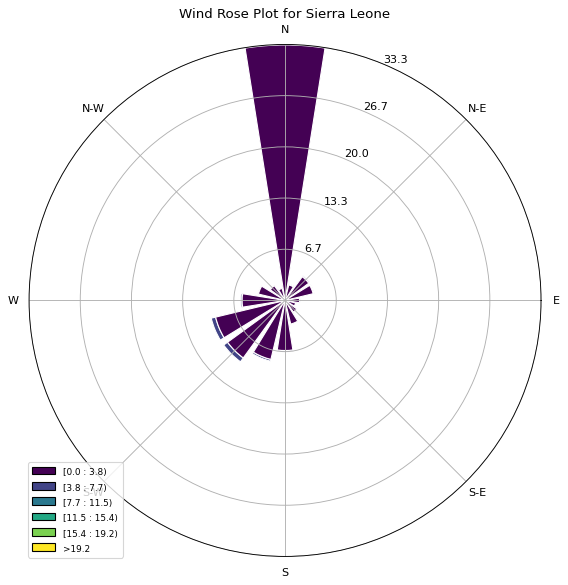

In [12]:
# Wind rose plot
ax = WindroseAxes.from_ax()
ax.bar(df['WD'], df['WS'], normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
plt.title('Wind Rose Plot for Sierra Leone')
plt.show()

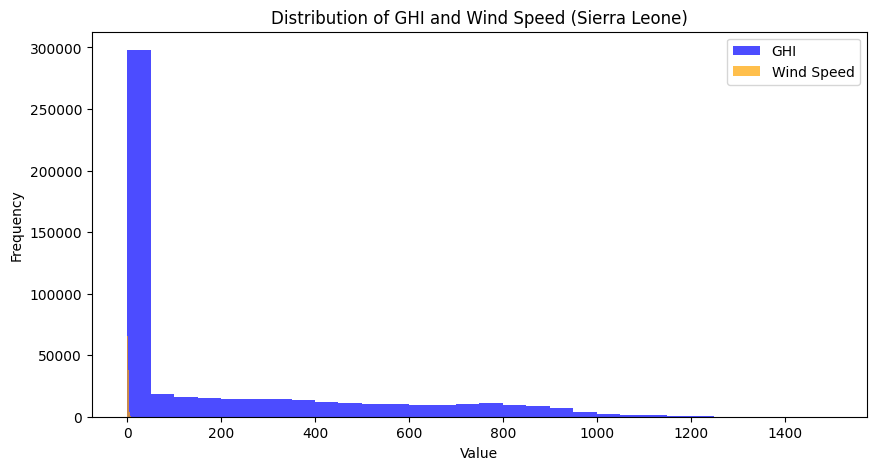

In [13]:
# Histograms
plt.figure(figsize=(10, 5))
plt.hist(df['GHI'], bins=30, alpha=0.7, label='GHI', color='blue')
plt.hist(df['WS'], bins=30, alpha=0.7, label='Wind Speed', color='orange')
plt.legend()
plt.title('Distribution of GHI and Wind Speed (Sierra Leone)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

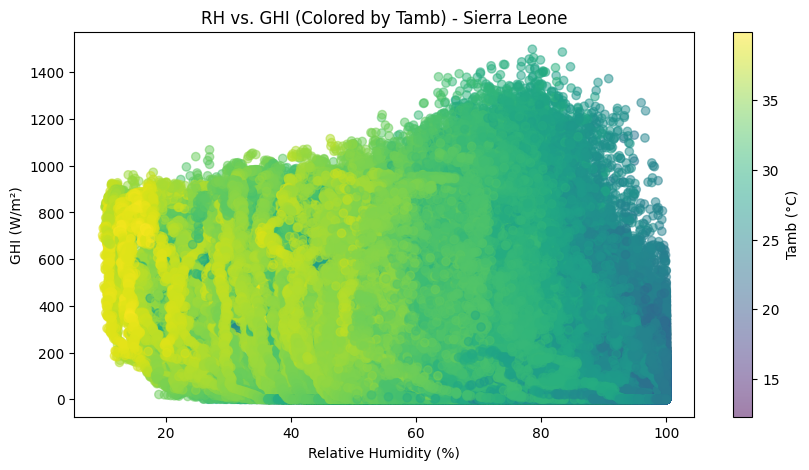

In [14]:
# Scatter plot: RH vs. GHI colored by Tamb
plt.figure(figsize=(10, 5))
scatter = plt.scatter(df['RH'], df['GHI'], c=df['Tamb'], cmap='viridis', alpha=0.5)
plt.colorbar(label='Tamb (°C)')
plt.xlabel('Relative Humidity (%)')
plt.ylabel('GHI (W/m²)')
plt.title('RH vs. GHI (Colored by Tamb) - Sierra Leone')
plt.show()

High RH may reduce GHI due to cloud cover.

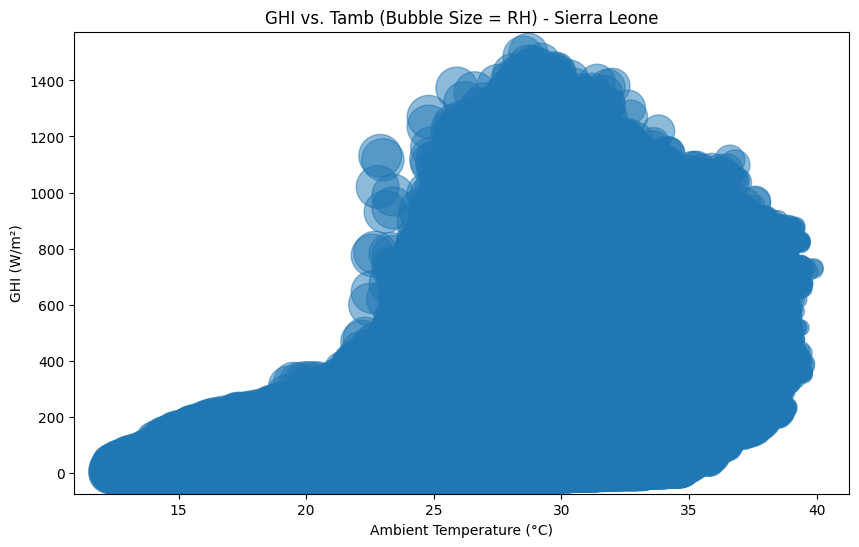

In [15]:
# Bubble chart: GHI vs. Tamb with RH as bubble size
plt.figure(figsize=(10, 6))
plt.scatter(df['Tamb'], df['GHI'], s=df['RH']*10, alpha=0.5)
plt.xlabel('Ambient Temperature (°C)')
plt.ylabel('GHI (W/m²)')
plt.title('GHI vs. Tamb (Bubble Size = RH) - Sierra Leone')
plt.show()

Higher RH correlates with lower GHI